# 1. Predicting temperature

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of [this dataset from Kaggle](https://www.kaggle.com/budincsevity/szeged-weather/home). To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

* First, load the dataset from the **weatherinszeged** table from Thinkful's database.
* Build a regression model where the target variable is *temperature*. As explanatory variables, use *humidity*, *windspeed*, *windbearing*, and *pressure*. Estimate the model using OLS.
* Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

Here are the credentials you can use to connect to the database:

```
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'
```

As in earlier assignments, be sure to close the database connection after initially pulling in your data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sqlalchemy import create_engine 
import statsmodels.api as sm 

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [3]:
weather_df.info()
#there is no missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


In [4]:
weather_df.describe()
#all values in loudcover are zeros 

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [5]:
cat = weather_df.select_dtypes(['object']).columns

print(cat)
print(len(cat))

Index(['summary', 'preciptype', 'dailysummary'], dtype='object')
3


In [6]:
num = weather_df.select_dtypes(['float64']).columns

print(num)
print(len(num))

Index(['temperature', 'apparenttemperature', 'humidity', 'windspeed',
       'windbearing', 'visibility', 'loudcover', 'pressure'],
      dtype='object')
8


## EDA

First, examine the distribution of the target variable temperature. The plot shows that temperature follows a normal distribution.

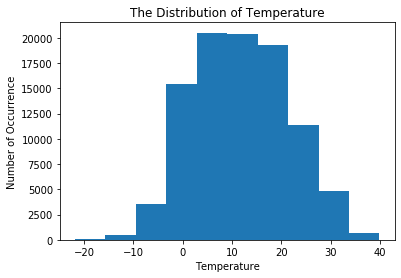

In [7]:
plt.hist(weather_df['temperature'])
plt.title('The Distribution of Temperature')
plt.xlabel('Temperature')
plt.ylabel('Number of Occurrence')
plt.show()

Next, examine the correlations between numeric variables and target variables regardless of signs by taking absolute values. 

In [8]:
np.abs(weather_df[num].corr().loc[:,'temperature']).sort_values(ascending=False)
#Hobson: apparent temperature is almost perfectly correlated with temperature, should we include it as a feature?

temperature            1.000000
apparenttemperature    0.992629
humidity               0.632255
visibility             0.392847
windbearing            0.029988
windspeed              0.008957
pressure               0.005447
loudcover                   NaN
Name: temperature, dtype: float64

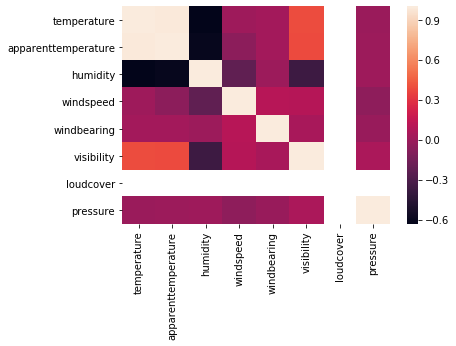

In [9]:
sns.heatmap(weather_df.corr())

plt.show()

Plot temperature by categorical variables. 

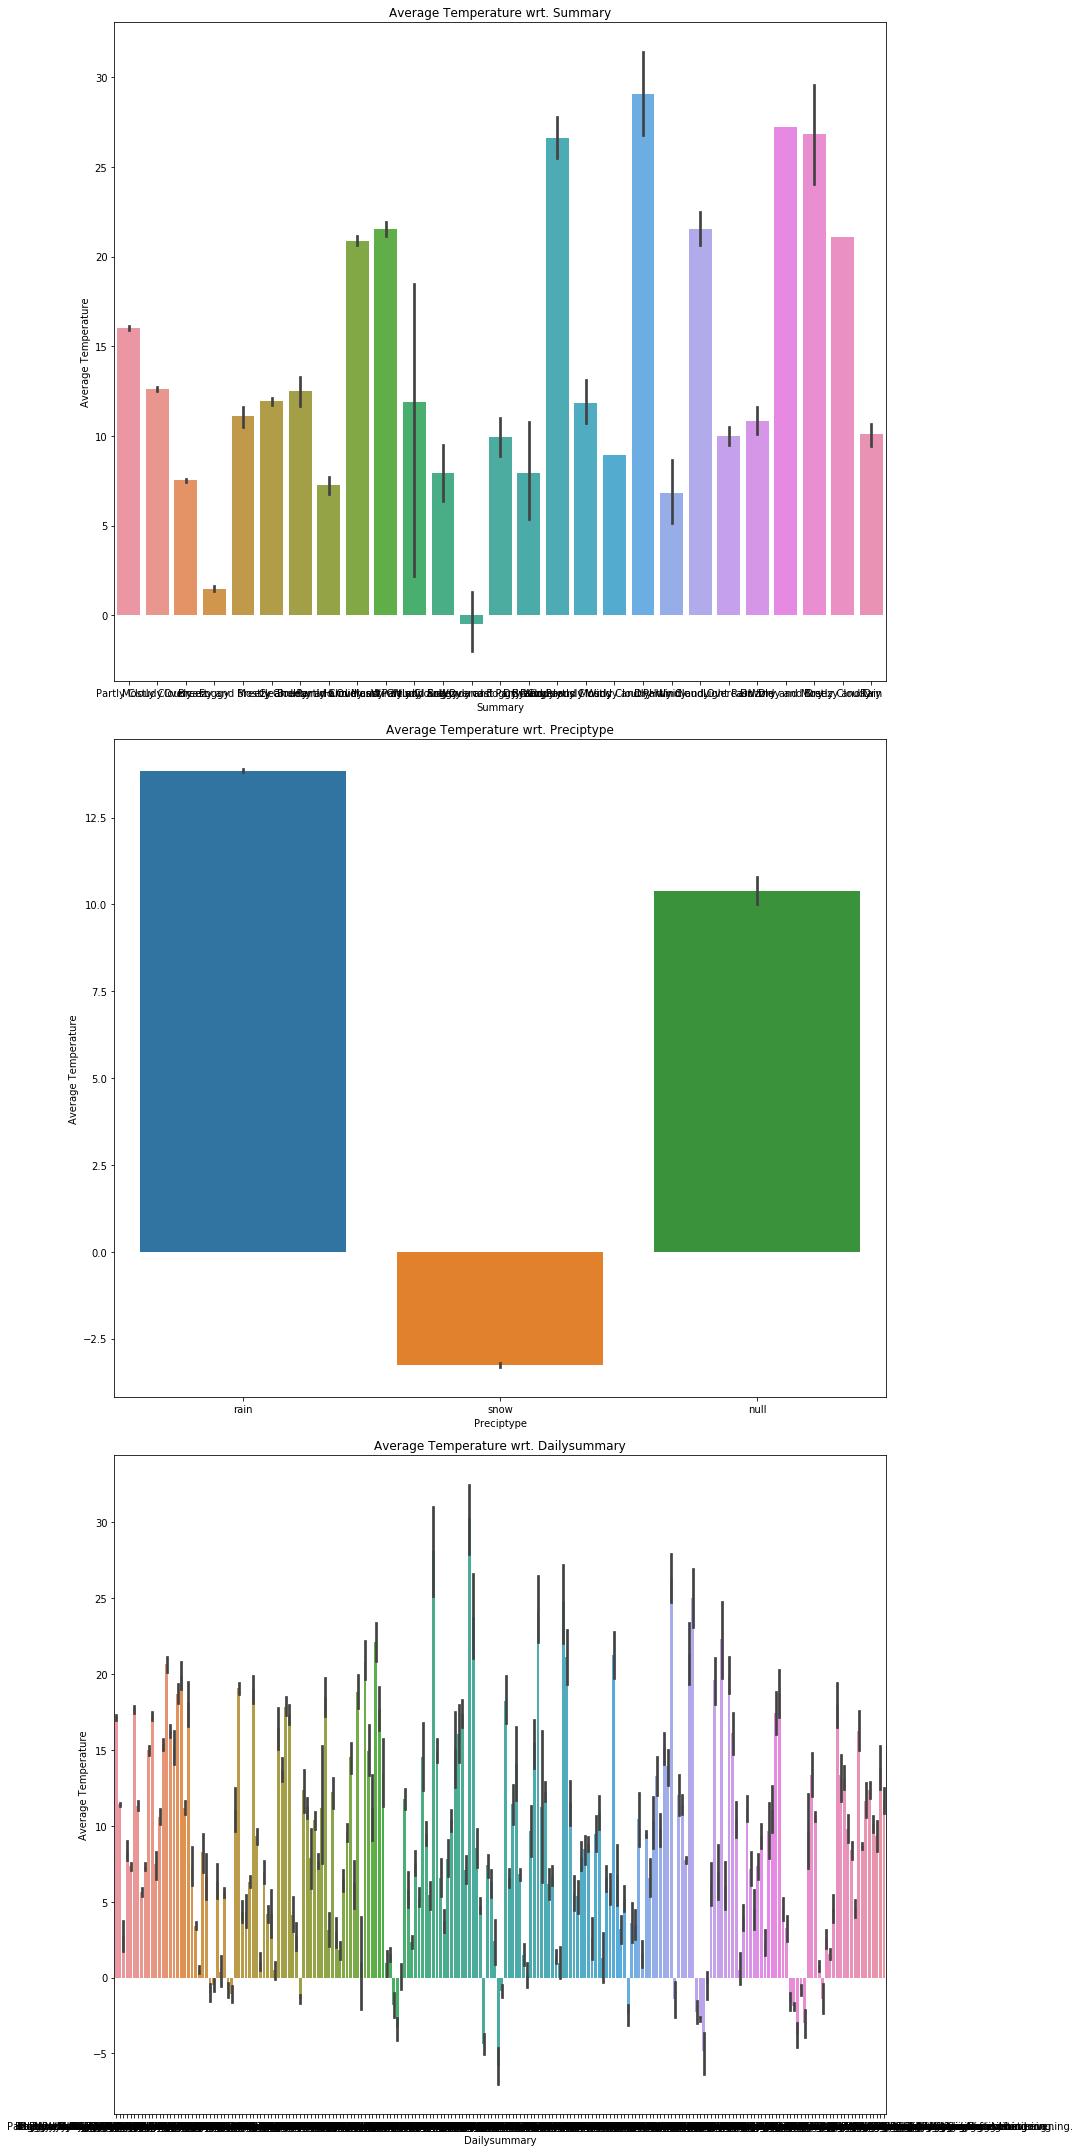

In [10]:
plt.figure(figsize=(15,30))

for i in range(len(cat)):
    plt.subplot(3,1,i+1)
    sns.barplot(x=cat[i], y='temperature', data=weather_df)
    plt.title('Average Temperature wrt. {}'.format(cat[i].capitalize()))
    plt.ylabel('Average Temperature')
    plt.xlabel('{}'.format(cat[i].capitalize()))
    
plt.tight_layout()
plt.show()

In [11]:
#convert preciptype to dummies 
weather_df = pd.concat([weather_df, 
                        pd.get_dummies(weather_df['preciptype'], prefix='preciptype', drop_first=True)], axis=1
                      )
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary,preciptype_rain,preciptype_snow
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,1,0
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,1,0
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,1,0
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,1,0
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,1,0


In [12]:
cat_column_names = list(weather_df.columns[-2:])
cat_column_names

['preciptype_rain', 'preciptype_snow']

## Regression model
As instructed the assignment, I use humidity, windspeed, windbearing, and pressure as explanatory variables. 

In [39]:
Y = weather_df['temperature']

X = weather_df[['humidity', 'windspeed', 'windbearing', 'pressure']]

X.head()

,humidity,windspeed,windbearing,pressure
0,0.89,14.1197,251.0,1015.13
1,0.86,14.2646,259.0,1015.63
2,0.89,3.9284,204.0,1015.94
3,0.83,14.1036,269.0,1016.41
4,0.83,11.0446,259.0,1016.51


In [40]:
X = sm.add_constant(X)

lin_reg = sm.OLS(Y, X).fit()

lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.750e+04
Date:                Fri, 04 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:09:27   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96448   BIC:                         6.565e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9264      0.233    162.709      0.000      37.470      38.383
humidity      -32.4962      0.123   -264.288      0.000     -32.737     -32.255
windspeed      -0.2014      0.003    -57.557      0.000      -0.208      -0.195
windbearing     0.0040      0.000     18.463      0.000       0.004       0.004
pressure       -0.0007      0.000     -3.452      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     3375.432   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3793.297
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Assumption one: linearity of the model in its coefficients

To detect nonlinearity, inspect plots of observed vs. predicted values or residuals vs. predicted values. The desired outcome is that points are symmetrically distributed around a diagonal line in the former plot or around a horizontal line in the latter one. In both cases with a roughly constant variance. 

The inspection of the plots shows that the linearity assumption is roughly satisfied.

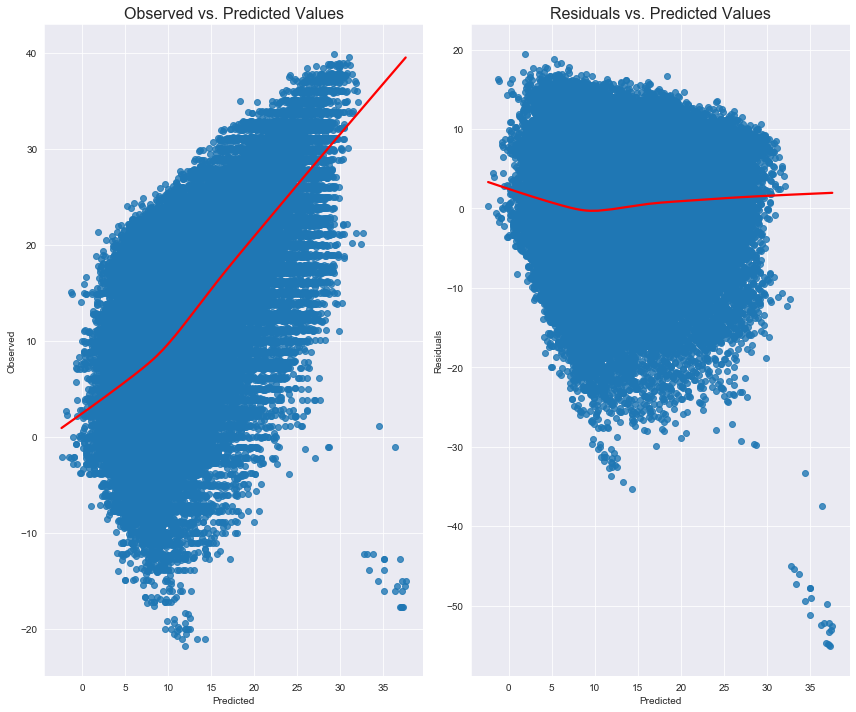

In [20]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,10))

fitted_vals = lin_reg.predict()
resids = lin_reg.resid

plt.subplot(1,2,1)
sns.regplot(x=fitted_vals, y=Y, lowess=True, line_kws={'color': 'red'})
plt.title ('Observed vs. Predicted Values', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Observed')

plt.subplot(1,2,2)
sns.regplot(x=fitted_vals, y=resids, lowess=True, line_kws={'color': 'red'})
plt.title ('Residuals vs. Predicted Values', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

## Assumption two: the error term should be zero on average

As we can see the assumption is met. 

In [24]:
print("Mean of the errors in the weather forcast model is: {}".format(lin_reg.resid.mean()))

Mean of the errors in the weather forcast model is: 1.7155101561120413e-11


## Assumption three: homoscedasticity

Use plot and tests to check. The test results reject the null hypothesis indicating the errors are heteroscedastic. This may be caused by outliers in the data and omitted variables that are important in explaining the variance of the target variable. 

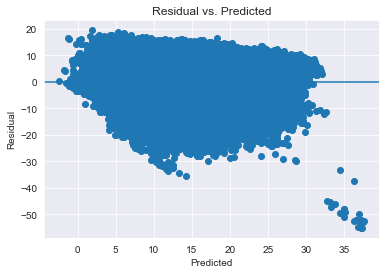

In [37]:
plt.scatter(fitted_vals, resids)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [38]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(fitted_vals, resids)
lev_stats = levene(fitted_vals, resids)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


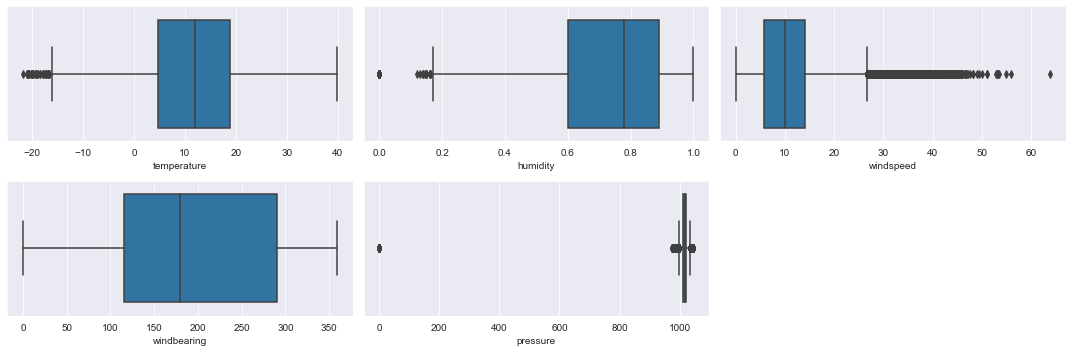

In [34]:
#check outlier
var = ['temperature', 'humidity', 'windspeed', 'windbearing', 'pressure']

plt.figure(figsize=(15,5))

for i in range(len(var)):
    plt.subplot(2,3,i+1)
    sns.boxplot(weather_df[var[i]])

plt.tight_layout()
plt.show()

## Assumption four: low multicollinearity

Detect multicollinearity using the variance inflation factor(VIF). If no features are correlated, then all values for VIF will be 1. As we can see from the results, the assumption is met.

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF']= [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif.round(1)

,VIF,features
0,99.1,const
1,1.1,humidity
2,1.1,windspeed
3,1.0,windbearing
4,1.0,pressure


## Assumption five: error terms should be uncorrelated with one another

As we can see from the plot.

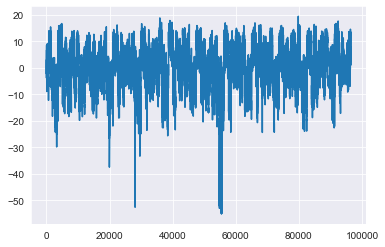

In [49]:
plt.plot(resids)
plt.show()

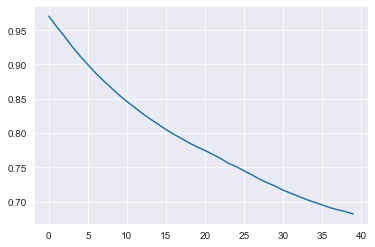

In [50]:
from statsmodels.tsa.stattools import acf

acf_data = acf(resids)

plt.plot(acf_data[1:])
plt.show()

## Assumption six: features shouldn't be correlated with the errors

To investigate this assumption I check the Pearson correlation coefficient between each feature and the residuals. Then report the p-value for testing the lack of correlation between the two considered series. All null hypothese cannot be rejected.

In [51]:
from scipy.stats.stats import pearsonr

for column in X.columns:
    corr_test = pearsonr(X[column], lin_reg.resid)
    print(f'Variable: {column} --- correlation: {corr_test[0]:.4f}, p-value: {corr_test[1]:.4f}')

Variable: const --- correlation: nan, p-value: nan
Variable: humidity --- correlation: -0.0000, p-value: 1.0000
Variable: windspeed --- correlation: 0.0000, p-value: 1.0000
Variable: windbearing --- correlation: 0.0000, p-value: 1.0000
Variable: pressure --- correlation: 0.0000, p-value: 1.0000
